In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ember-2017-v2-features/train_ember_2017_v2_features.parquet
/kaggle/input/ember-2017-v2-features/test_ember_2017_v2_features.parquet


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score, auc, RocCurveDisplay
from fastcore.basics import *
from fastcore.parallel import *
from os import cpu_count
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_parquet('/kaggle/input/ember-2017-v2-features/train_ember_2017_v2_features.parquet')
df_test = pd.read_parquet('/kaggle/input/ember-2017-v2-features/test_ember_2017_v2_features.parquet')

In [4]:
df_train.Label.value_counts()

Label
 0.0    299992
-1.0    299973
 1.0    299793
Name: count, dtype: int64

In [5]:
df_train = df_train[df_train['Label'].isin([0,1])]

In [6]:
df_train.Label.value_counts()

Label
0.0    299992
1.0    299793
Name: count, dtype: int64

In [7]:
df_test.Label.value_counts()

Label
0.0    99996
1.0    99984
Name: count, dtype: int64

In [8]:
cats = list(df_train.select_dtypes(include='category').columns.values)
cats

[]

In [9]:
df_train.isna().sum().sort_values(ascending=False)

F1       0
F1583    0
F1585    0
F1586    0
F1587    0
        ..
F795     0
F796     0
F797     0
F798     0
Label    0
Length: 2382, dtype: int64

In [10]:
def xs_y(df_, targ): 
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y

In [11]:
def evaluate_one_feature(feature, index='', metric=roc_auc_score):    
    rootnode = DecisionTreeClassifier(max_depth=1, criterion='gini', class_weight='balanced')    
    rootnode.fit(X_train[feature].array.reshape(-1,1), y_train)    
    preds = rootnode.predict(X_test[feature].array.reshape(-1,1))
    preds_tr = rootnode.predict(X_train[feature].array.reshape(-1,1))
    met = round(metric(y_test, preds), 4)
    if met > 0.5:
        return [feature, met, rootnode, preds, preds_tr]
    else:
        return [feature, met, None, [], []]

In [12]:
target = 'Label'
conts = list(df_train.columns.difference([target]).values) 

In [13]:
X_train, y_train = xs_y(df_train, targ=target)
X_test, y_test = xs_y(df_test, targ=target)

In [14]:
import gc
del [[df_train, df_test]]
gc.collect()
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [15]:
results = parallel(f=evaluate_one_feature, items=conts, n_workers=cpu_count(), threadpool=False, progress=True)

In [16]:
result_df = pd.DataFrame(data=results, columns=['feature', 'roc_auc_score', 'fitted_models', 'predictions', 'preds_train']).sort_values(by='roc_auc_score', ascending=False)
print(result_df[['feature', 'roc_auc_score']].head(10))
useful_features = result_df.loc[result_df['roc_auc_score'] > 0.5]
print(f"{len(useful_features)} / {len(conts)} features have direct separating power (linear)")

     feature  roc_auc_score
2000    F656         0.8118
1999    F655         0.8016
190     F117         0.7964
2003    F659         0.7926
135     F112         0.7922
1553    F253         0.7920
1980    F638         0.7854
124     F111         0.7816
79      F107         0.7795
1423    F228         0.7789
2200 / 2381 features have direct separating power (linear)


In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

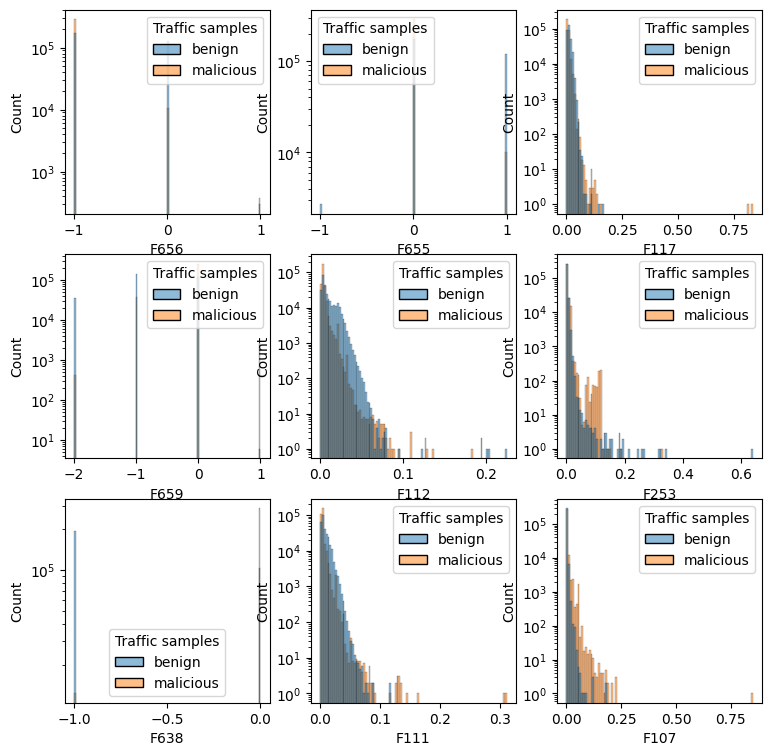

In [18]:
fig, axes = plt.subplots(3,3, figsize=(9,9))
axes = axes.flatten()
for i, tf in enumerate(result_df['feature'].head(9)):
    sns.histplot(data=pd.concat(objs=[X_train,y_train],axis=1), x=tf, stat='count', hue='Label', bins=100, log_scale=(False,True), ax=axes[i])
    axes[i].tick_params(axis='x', rotation=0)
    legend = axes[i].get_legend()
    handles = legend.legend_handles
    legend.remove()
    axes[i].legend(handles, ['benign', 'malicious'], title='Traffic samples')
#axes[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.savefig("ember-2018-V2F-top9.png", dpi=300, transparent=True, facecolor='white', edgecolor='white')

In [19]:
ensemble_preds = np.mean(np.vstack(useful_features['predictions'].to_numpy()), axis=0)
print(ensemble_preds.shape)
ensemble_preds_train = np.mean(np.vstack(useful_features['preds_train'].to_numpy()), axis=0)
print(ensemble_preds_train.shape)

(199980,)
(599785,)


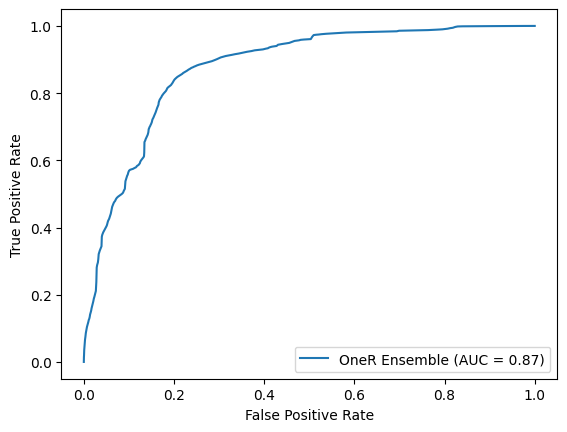

In [20]:
fpr, tpr, thresholds = roc_curve(y_train, ensemble_preds_train)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='OneR Ensemble')
display.plot()

In [21]:
print("Best threshold", round(best_thresh, 4))
print("The Ensemble OneR model (simple average)")
print("ROC-AUC", round(roc_auc_score(y_true=y_test, y_score=ensemble_preds),4))
print("Precision", round(precision_score(y_true=y_test, y_pred=np.where(ensemble_preds >= best_thresh, 1, 0)), 4))
print("Recall", round(recall_score(y_true=y_test, y_pred=np.where(ensemble_preds >= best_thresh, 1, 0)), 4))
print("F1", round(f1_score(y_true=y_test, y_pred=np.where(ensemble_preds >= best_thresh, 1, 0)), 4))

Best threshold 0.7868
The Ensemble OneR model (simple average)
ROC-AUC 0.8791
Precision 0.8435
Recall 0.7075
F1 0.7696
